In [9]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.font_manager as fm
import matplotlib as mpl

weather = pd.read_csv("../../data/raw/weather.csv", encoding='euc-kr')
weather_location = pd.read_csv("../../data/raw/weather_station_info.csv", encoding='euc-kr')

In [10]:
weather[['year', 'month']] = weather['일시'].str.split('-', expand=True)
weather['year'] = weather['year'].astype(int)
weather['month'] = weather['month'].astype(int)

In [11]:
def season_month(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'fall'
    else:
        return 'winter'

weather['season'] = weather['month'].apply(season_month)
avg_by_month = weather.groupby(['지점', 'season'])[weather.columns[3:15]].mean().reset_index()

In [12]:
weather_location = weather_location[['지점', '위도', '경도','노장해발고도(m)']]
weather = weather.merge(weather_location[['지점', '위도', '경도']], on='지점', how='left')

In [13]:
korea_map = gpd.read_file('../../data/raw/map.shp', encoding='euc-kr')  # CRS는 확인해서 필요시 재설정
if korea_map.crs is None:
    korea_map.set_crs("EPSG:5179", inplace=True)
korea_map = korea_map.to_crs("EPSG:4326")  # 위도경도와 맞추기 위해 WGS84로 변환

gdf_points = gpd.GeoDataFrame(
    weather,
    geometry=gpd.points_from_xy(weather['경도'], weather['위도']),
    crs="EPSG:4326"
)

joined = gpd.sjoin(gdf_points, korea_map, how='left', predicate='within')
avg_rainfall = joined.groupby(['CTP_KOR_NM', 'season'])['월합강수량(00~24h만)(mm)'].mean().reset_index()

### 1. Summer

In [14]:
summer_rainfall = avg_rainfall[avg_rainfall['season'] == 'summer']
summer_map = korea_map.merge(summer_rainfall, on='CTP_KOR_NM')

In [15]:
def plot_rainfall_and_bee_data(shp_file, summer_rainfall, bee_csv_file):
    #한글 폰트
    font_path = 'C:/Windows/Fonts/malgun.ttf'
    fontprop = fm.FontProperties(fname=font_path)
    mpl.rc('font', family=fontprop.get_name())
    mpl.rcParams['axes.unicode_minus'] = False

    korea_map = gpd.read_file(shp_file)
    
    if korea_map.crs is None:
        korea_map.set_crs("EPSG:5179", inplace=True)
    korea_map = korea_map.to_crs("EPSG:4326")

    fig, ax = plt.subplots(figsize=(10, 10))
    summer_map.plot(column='월합강수량(00~24h만)(mm)', cmap='Blues', linewidth=0.8, edgecolor='gray', legend=True, ax=ax)
    plt.title('Average Rainfall of Summer with SBV')
    
    bee_data = pd.read_csv(bee_csv_file, encoding='euc-kr')
    bee_data = bee_data[['Longitude', 'Latitude', '발생두수', '축종']].dropna()

    unique_species = bee_data['축종'].unique()
    colors = ['#FFDF33', '#108593', '#658E06', '#8625DB', 'purple', 'cyan', 'magenta']
    color_map = {species: colors[i % len(colors)] for i, species in enumerate(unique_species)}
    bee_data['color'] = bee_data['축종'].map(color_map)
    
    min_size = 2
    max_size = 50
    bee_data['size'] = (bee_data['발생두수'] / bee_data['발생두수'].max()) * (max_size - min_size) + min_size

    for species in unique_species:
        df = bee_data[bee_data['축종'] == species]
        ax.scatter(df['Longitude'], df['Latitude'],
                s=df['size'], color=color_map[species],
                label=species, alpha=0.7)
    ax.legend(title='bee type', loc='lower right')
    #plt.axis('off')
    plt.savefig('../../outputs/figures/2_2_1_AvgRainfall_Summer_SBV.png', dpi=300, bbox_inches='tight')
    plt.show()

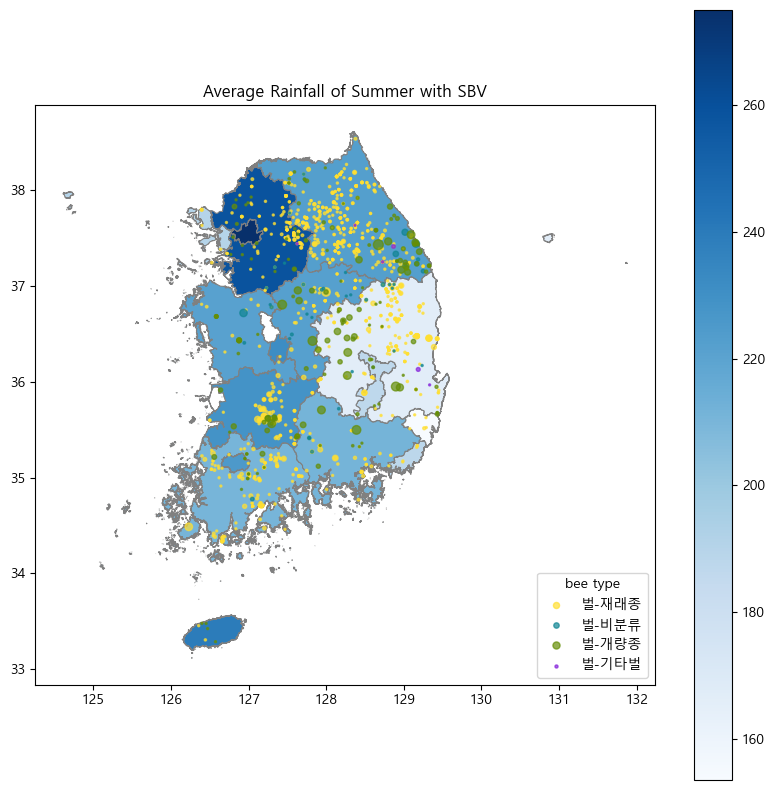

In [16]:
if __name__ == "__main__":
    plot_rainfall_and_bee_data('../../data/raw/map.shp', summer_rainfall, '../../data/raw/SBV_Infection_Location.csv')

### 2. Winter

In [17]:
winter_rainfall = avg_rainfall[avg_rainfall['season'] == 'winter']
winter_map = korea_map.merge(winter_rainfall, on='CTP_KOR_NM')

In [18]:
def plot_rainfall_and_bee_data(shp_file, winter_rainfall, bee_csv_file):
    #한글 폰트
    font_path = 'C:/Windows/Fonts/malgun.ttf'
    fontprop = fm.FontProperties(fname=font_path)
    mpl.rc('font', family=fontprop.get_name())
    mpl.rcParams['axes.unicode_minus'] = False

    korea_map = gpd.read_file(shp_file)
    
    if korea_map.crs is None:
        korea_map.set_crs("EPSG:5179", inplace=True)
    korea_map = korea_map.to_crs("EPSG:4326")

    fig, ax = plt.subplots(figsize=(10, 10))
    winter_map.plot(column='월합강수량(00~24h만)(mm)', cmap='Blues', linewidth=0.8, edgecolor='gray', legend=True, ax=ax)
    plt.title('Average Rainfall of Winter with SBV')
    
    bee_data = pd.read_csv(bee_csv_file, encoding='euc-kr')
    bee_data = bee_data[['Longitude', 'Latitude', '발생두수', '축종']].dropna()

    unique_species = bee_data['축종'].unique()
    colors = ['#FFDF33', '#108593', '#658E06', '#8625DB', 'purple', 'cyan', 'magenta']
    color_map = {species: colors[i % len(colors)] for i, species in enumerate(unique_species)}
    bee_data['color'] = bee_data['축종'].map(color_map)
    
    min_size = 2
    max_size = 50
    bee_data['size'] = (bee_data['발생두수'] / bee_data['발생두수'].max()) * (max_size - min_size) + min_size

    for species in unique_species:
        df = bee_data[bee_data['축종'] == species]
        ax.scatter(df['Longitude'], df['Latitude'],
                s=df['size'], color=color_map[species],
                label=species, alpha=0.7)
    ax.legend(title='bee type', loc='lower right')
    #plt.axis('off')
    plt.savefig('../../outputs/figures/2_2_2_AvgRainfall_Winter_SBV.png', dpi=300, bbox_inches='tight')
    plt.show()

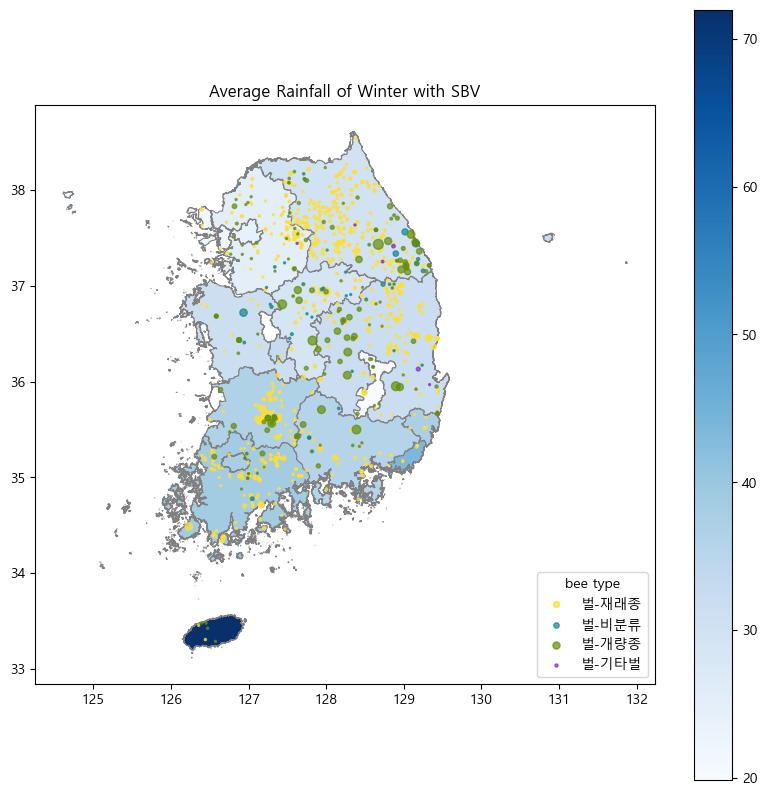

In [19]:
if __name__ == "__main__":
    plot_rainfall_and_bee_data('../../data/raw/map.shp', winter_rainfall, '../../data/raw/SBV_Infection_Location.csv')